## Generate correlated features 

To be concrete, suppose: 

* x1 is number of CpG sites in genomic interval (observed) 
* x2 is “dosage of the mutational pathway that causes COSMIC signature 5” (unobserved)
* x3 is "dosage of COSMIC signature 5" (observed) 

The COSMIC mutation signature #5 is common across many cell types and is associated with aging but is of unknown etiology. You can infer the dosage of the signature (x3) but, because we don’t know the true etiology, the dosage of the signature is just a proxy for the dosage of whatever mutational pathway underlies it. So “dosage of the mutational pathway that causes signature 5” (x2) would be a very helpful variable in a window but is not directly observable. 










Text(0, 0.5, 'x2')

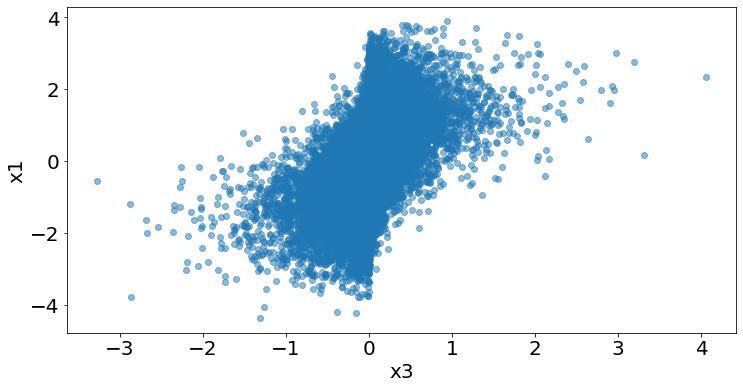

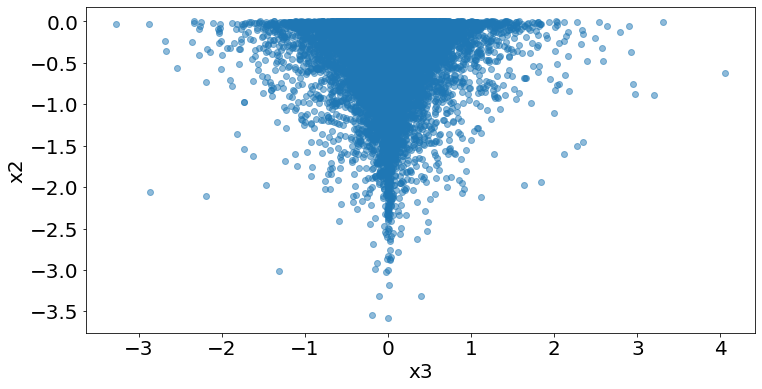

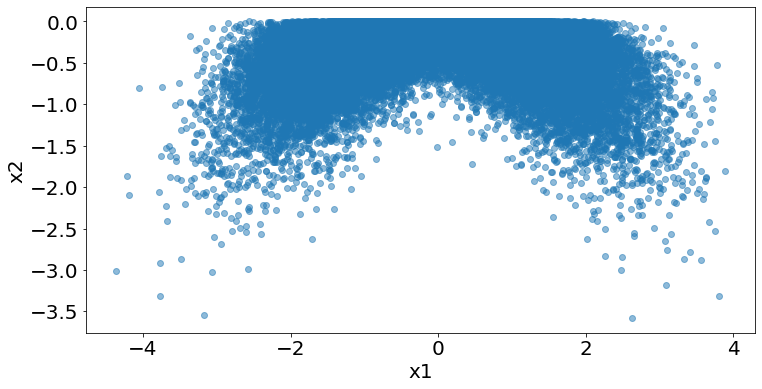

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES = 100000 # Number of intervals

MEAN = [0, 0, 0]  # Means for the three features

# Covariance matrix (symmetric and positive-definite)
# we need non-zero covariances to exhibit the bias in residuals as a function of x1, but not as a function of x2
COV = [
    [1.0, 0.8, 0.5],  # Variance of X1 and covariances with X2 and X3
    [0.8, 1.0, 0.3],  # Covariance of X2 with X1 and variance of X2 and covariance with X3
    [0.5, 0.3, 1.0]   # Covariance of X3 with X1 and X2 and variance of X3
]
# COV = [
#     [1.0, 0.0, 0.0],  # Variance of X1 and covariances with X2 and X3
#     [0.0, 1.0, 0.0],  # Covariance of X2 with X1 and variance of X2 and covariance with X3
#     [0.0, 0.0, 1.0]   # Covariance of X3 with X1 and X2 and variance of X3
# ]

x1s, x2s, x3s = np.random.multivariate_normal(MEAN, COV, size=NUMBER_EXAMPLES).T

x2s = -0.2 * x2s**2 
x3s = +0.05 * x3s**3

plt.figure(figsize=(12, 6))
plt.plot(x3s, x1s, 'o', alpha=0.5)
plt.xlabel('x3')
plt.ylabel('x1')

plt.figure(figsize=(12, 6))
plt.plot(x3s, x2s, 'o', alpha=0.5)
plt.xlabel('x3')
plt.ylabel('x2')

plt.figure(figsize=(12, 6))
plt.plot(x1s, x2s, 'o', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')

## True mapping from features to target (mimicking SNV counts)

Recall: 

* x1 is number of CpG sites in genomic interval (observed) 
* x2 is “dosage of the mutational pathway that causes COSMIC signature 5” (unobserved)
* x3 is "dosage of COSMIC signature 5" (observed) 

Though x3 is correlated with x2 (and x1 in our example), x3 does not directly affect mutation rate. Later, we will fit data using the variables we can observe: x1 and x3. 

Text(0, 0.5, 'number of examples')

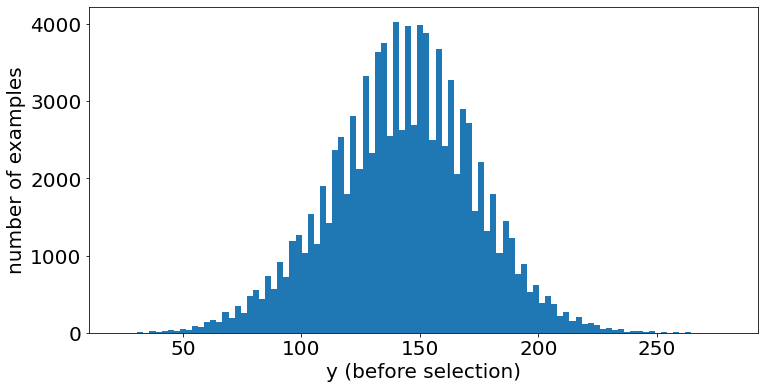

In [2]:
# parameters of true model 
A = 5 
B1 = 0.2 # 0.05 
B2 = 0.3

TRUE_RATE = lambda x1, x2: np.exp(A + B1*x1 + B2*x2) # rate function

ys = np.random.poisson(lam=TRUE_RATE(x1s, x2s)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=100)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')

## Introduce selection into a small fraction of examples

In [3]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x1), 
# to mimic the effect of negative selection (and how it occurs more often in regions with higher GC content)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2
FRACTIONAL_REDUCTION_IN_Y = 0.1

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)
# x1_factor = (x1s - x1s.min()) / (x1s.max() - x1s.min())
# y_pos = ys[:num_pos] * (1 - max_fractional_reduction_in_y * x1_factor[:num_pos])
y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y)
y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x1': x1s, 'x2': x2s, 'x3': x3s, 'y': ys, 'constrained': constrained})
DATA

,x1,x2,x3,y,constrained
0,-0.476779,-0.011873,-1.436476e-01,116.1,True
1,1.288116,-0.213286,6.787496e-02,172.8,True
2,-1.518303,-0.290030,-9.000489e-04,102.6,True
3,2.318667,-0.591188,2.645875e-02,151.2,True
4,-1.779051,-0.338781,-8.313633e-03,82.8,True
...,...,...,...,...,...
99995,-0.803395,-0.113782,-5.539533e-03,117.0,False
99996,-1.901875,-0.391811,4.411893e-06,91.0,False
99997,1.123775,-0.069450,-3.672713e-03,186.0,False
99998,0.923905,-0.400849,3.946029e-04,156.0,False


<AxesSubplot:xlabel='x3', ylabel='y'>

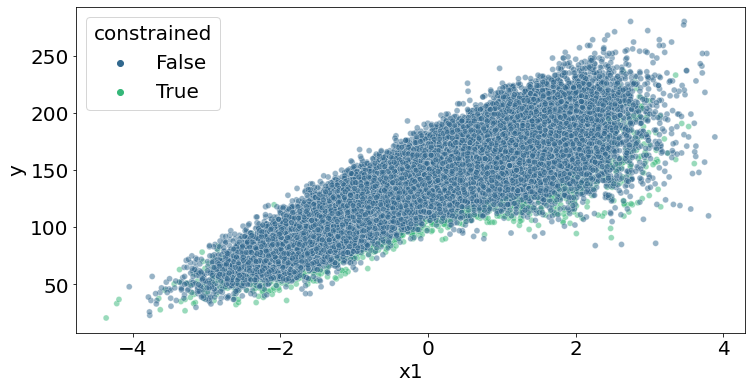

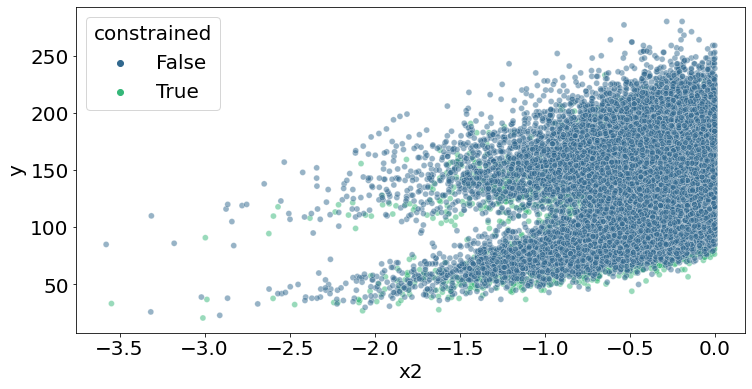

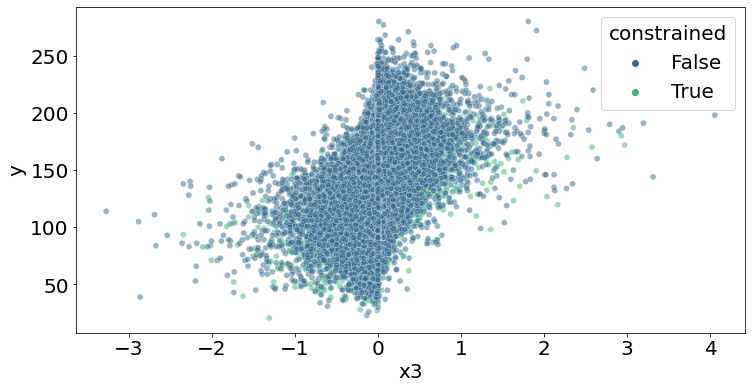

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x1', y='y', hue='constrained', palette='viridis', alpha=0.5)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x2', y='y', hue='constrained', palette='viridis', alpha=0.5)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x3', y='y', hue='constrained', palette='viridis', alpha=0.5)


## Approximate models of neutral data

In [5]:
import statsmodels.api as sm

def fit_poisson_model(features, model_index):
    data_neg = DATA[DATA['constrained'] == 0]
    x_model_neg = sm.add_constant(data_neg[features])
    model = sm.Poisson(data_neg['y'], x_model_neg).fit()
    x_model = sm.add_constant(DATA[features])
    DATA[f'predicted_y_model{model_index}'] = model.predict(x_model)
    DATA[f'standardized_residuals_model{model_index}'] = (
        DATA[f'predicted_y_model{model_index}'] - DATA['y'] 
    ) / np.sqrt(DATA[f'predicted_y_model{model_index}'])
    return model.params

print('True coefficients:', A, B1, B2)

# Fit Poisson Model 1: y ~ x1 (one of the two observed features)
coefficients_model1 = fit_poisson_model(['x1'], model_index=1)
print("Coefficients for Model 1:", coefficients_model1)

# Fit Poisson Model 2: y ~ x1 + x3 (both observed features)
coefficients_model2 = fit_poisson_model(['x1', 'x3'], model_index=2)
print("Coefficients for Model 2:", coefficients_model2)

# Fit Poisson Model 3: y ~ x1 + x2 (truth: x1 and x2 are the two features that directly affect mutation rate)
coefficients_model3 = fit_poisson_model(['x1', 'x2'], model_index=3)
print("Coefficients for Model 3:", coefficients_model3)

DATA

True coefficients: 5 0.2 0.3
Optimization terminated successfully.
         Current function value: 4.334947
         Iterations 4
Coefficients for Model 1: const    4.944873
x1       0.185284
dtype: float64
Optimization terminated successfully.
         Current function value: 4.334920
         Iterations 4
Coefficients for Model 2: const    4.944874
x1       0.185029
x3       0.003422
dtype: float64
Optimization terminated successfully.
         Current function value: 3.889553
         Iterations 5
Coefficients for Model 3: const    5.000200
x1       0.199849
x2       0.300861
dtype: float64


,x1,x2,x3,y,constrained,predicted_y_model1,standardized_residuals_model1,predicted_y_model2,standardized_residuals_model2,predicted_y_model3,standardized_residuals_model3
0,-0.476779,-0.011873,-1.436476e-01,116.1,True,128.577690,1.100402,128.530236,1.096419,134.470441,1.584186
1,1.288116,-0.213286,6.787496e-02,172.8,True,178.312931,0.412849,178.296090,0.411607,180.090523,0.543267
2,-1.518303,-0.290030,-9.000489e-04,102.6,True,106.012365,0.331419,106.053121,0.335313,100.434980,-0.216033
3,2.318667,-0.591188,2.645875e-02,151.2,True,215.828558,4.399163,215.721013,4.392937,197.495913,3.294303
4,-1.779051,-0.338781,-8.313633e-03,82.8,True,101.012396,1.812090,101.055371,1.815980,93.947178,1.150067
...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.803395,-0.113782,-5.539533e-03,117.0,False,121.027353,0.366082,121.049934,0.368100,122.169561,0.467705
99996,-1.901875,-0.391811,4.411893e-06,91.0,False,98.739588,0.778883,98.787495,0.783514,90.218264,-0.082302
99997,1.123775,-0.069450,-3.672713e-03,186.0,False,172.965163,-0.991120,172.913721,-0.995180,181.978872,-0.298083
99998,0.923905,-0.400849,3.946029e-04,156.0,False,166.676941,0.827007,166.638163,0.824099,158.260381,0.179678


In [6]:
def plot_ys(constrained, feature):
    df = DATA[DATA['constrained'] == constrained].copy()

    df[f'{feature}_bin_midpoints'] = (pd
        .cut(df[feature], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )
    average_y = df.groupby(f'{feature}_bin_midpoints')['y'].mean()  
    average_y_pred_model1 = df.groupby(f'{feature}_bin_midpoints')['predicted_y_model1'].mean()  
    average_y_pred_model2 = df.groupby(f'{feature}_bin_midpoints')['predicted_y_model2'].mean()  
    average_y_pred_model3 = df.groupby(f'{feature}_bin_midpoints')['predicted_y_model3'].mean()  

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model1'], 'o', alpha=0.5, label='Predicted y')
    plt.plot(average_y.index, average_y.values, color='red', lw=3, label=f'True-y average') 
    plt.plot(average_y_pred_model1.index, average_y_pred_model1.values, color='black', lw=3, label=f'Predicted-y average')  
    plt.xlabel(feature)
    plt.title('Model 1')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model2'], 'o', alpha=0.5, label='Predicted y')
    plt.plot(average_y.index, average_y.values, color='red', lw=3, label=f'True-y average') 
    plt.plot(average_y_pred_model2.index, average_y_pred_model2.values, color='black', lw=3, label=f'Predicted-y average')  
    plt.xlabel(feature)
    plt.title('Model 2')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model3'], 'o', alpha=0.5, label='Predicted y')
    plt.plot(average_y.index, average_y.values, color='red', lw=3, label=f'True-y average') 
    plt.plot(average_y_pred_model3.index, average_y_pred_model3.values, color='black', lw=3, label=f'Predicted-y average')  
    plt.xlabel(feature)
    plt.title('Model 3')
    plt.legend()

def plot_ys_all(constrained):
    plot_ys(constrained, 'x1')
    plot_ys(constrained, 'x2')
    plot_ys(constrained, 'x3')

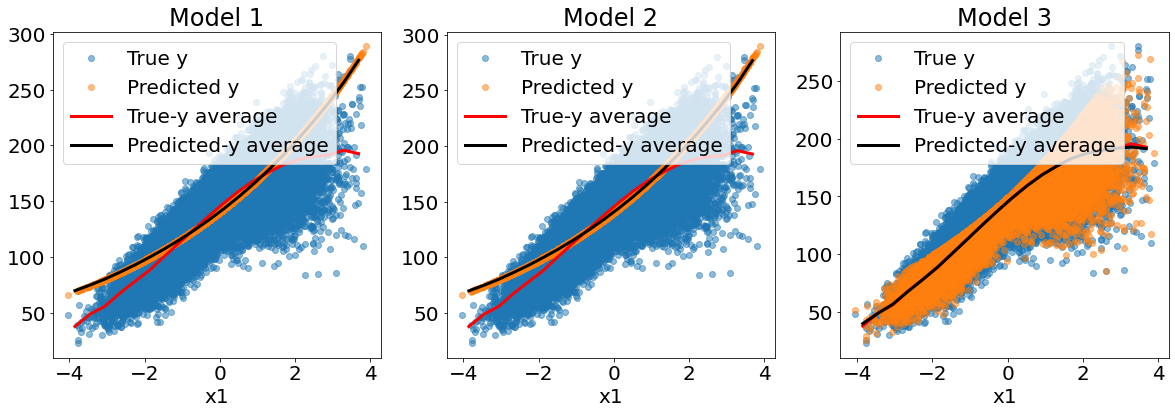

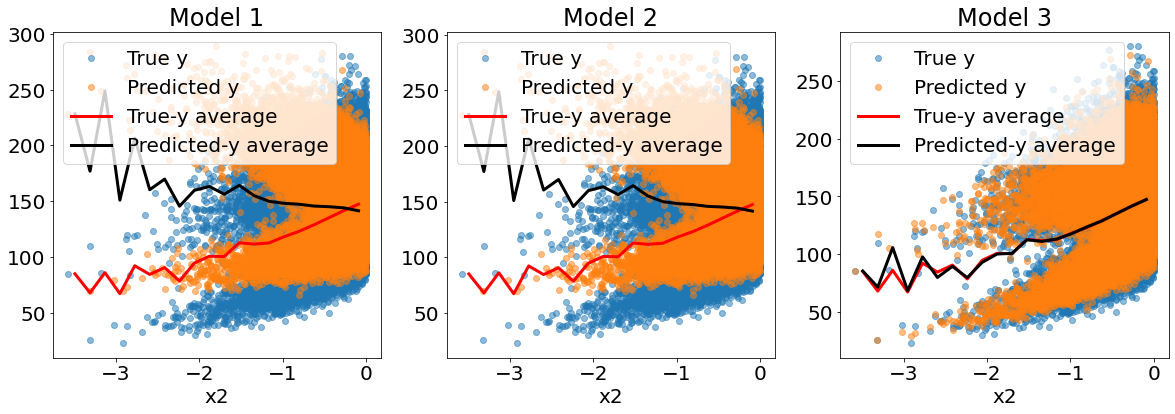

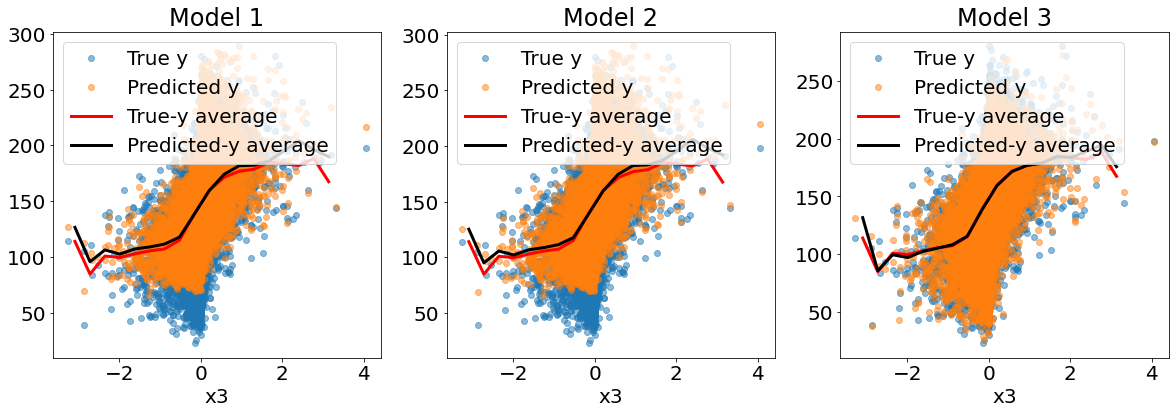

In [7]:
plot_ys_all(constrained=False)

## Variations in the complexity of a model, and the relevance of the features it includes, can result in radically different residual patterns

In [8]:
def plot_residuals(constrained, model_index, stratification_feature):
    df = DATA[DATA['constrained'] == constrained].copy()

    df[f'{stratification_feature}_bin_midpoints'] = (pd
        .cut(df[stratification_feature], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )
    average_residual = df.groupby(f'{stratification_feature}_bin_midpoints')[f'standardized_residuals_model{model_index}'].mean()  

    plt.subplot(1, 3, model_index)
    plt.scatter(df[stratification_feature], df[f'standardized_residuals_model{model_index}'], alpha=0.7, label='standardized residuals')
    plt.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'average') 
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'Model {model_index}')
    plt.xlabel(stratification_feature)
    plt.ylim(-10, 10)
    plt.xlim(-5, 5)
    plt.legend()

def plot_residuals_wrapper(constrained, stratification_feature):
    plt.figure(figsize=(20, 6))
    plot_residuals(constrained, model_index=1, stratification_feature=stratification_feature)
    plot_residuals(constrained, model_index=2, stratification_feature=stratification_feature)
    plot_residuals(constrained, model_index=3, stratification_feature=stratification_feature)


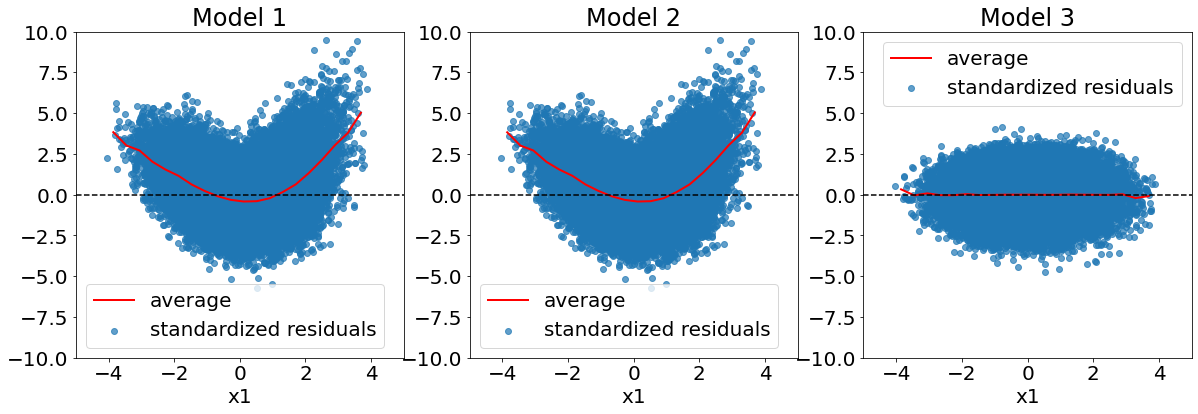

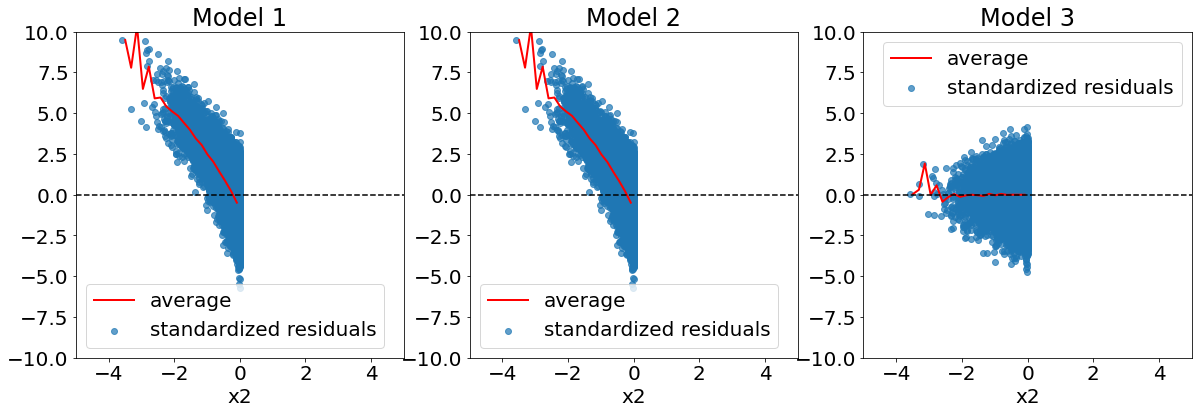

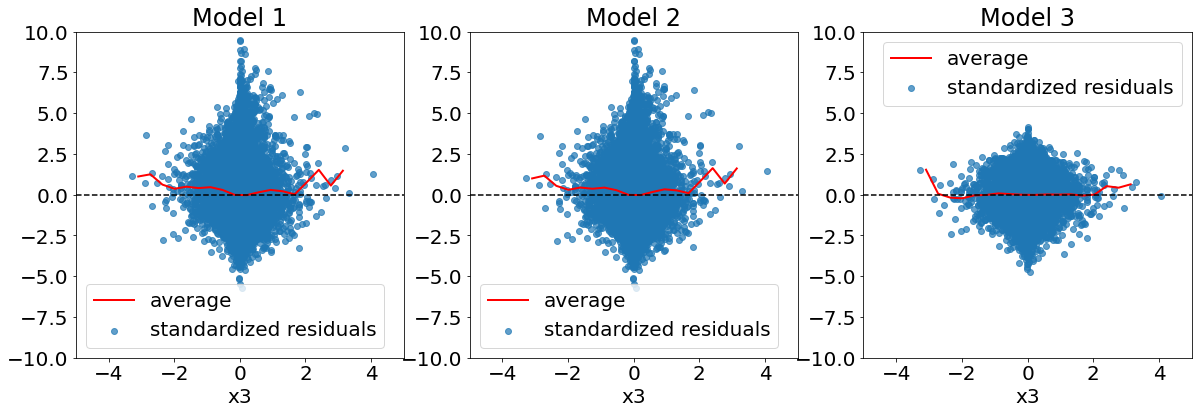

In [9]:
plot_residuals_wrapper(constrained=False, stratification_feature='x1')
plot_residuals_wrapper(constrained=False, stratification_feature='x2')
plot_residuals_wrapper(constrained=False, stratification_feature='x3')

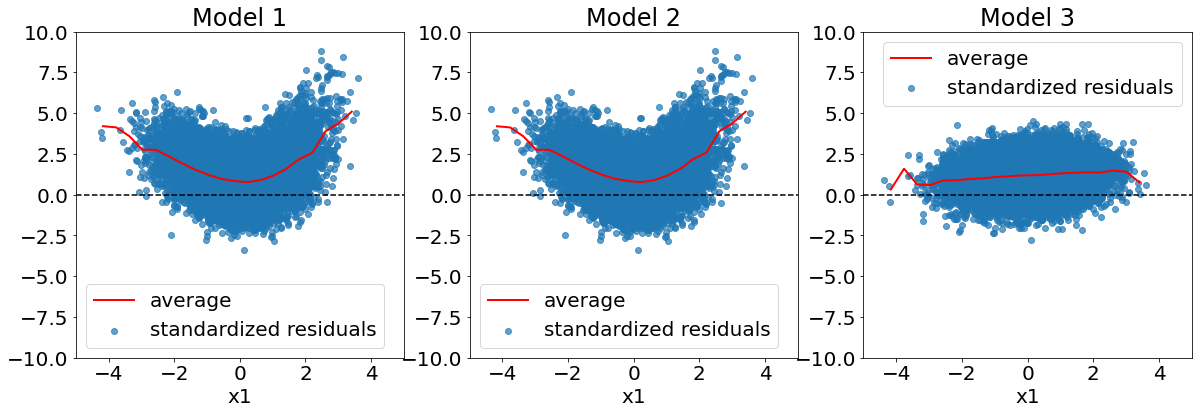

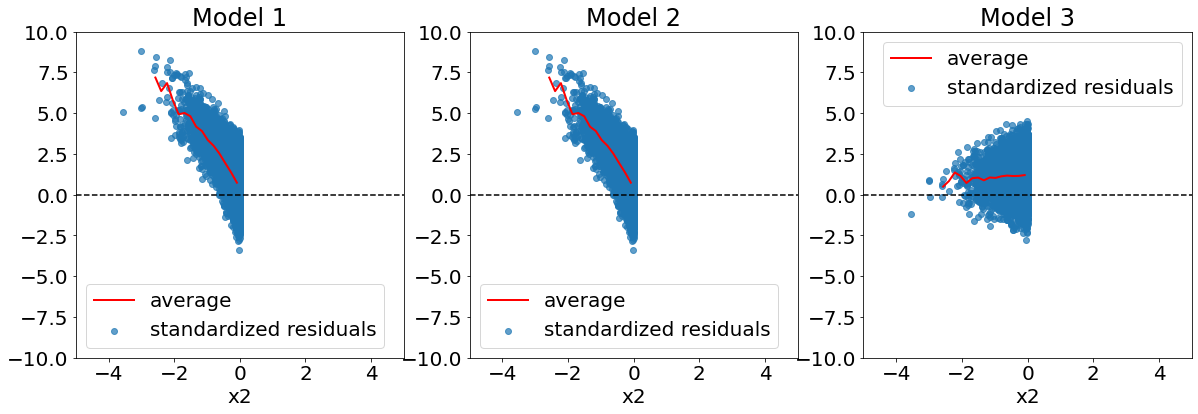

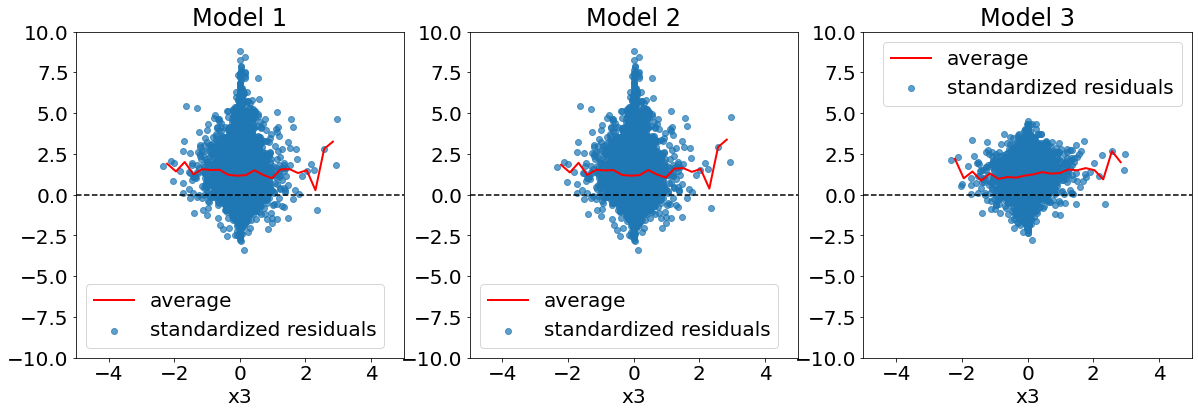

In [10]:
plot_residuals_wrapper(constrained=True, stratification_feature='x1')
plot_residuals_wrapper(constrained=True, stratification_feature='x2')
plot_residuals_wrapper(constrained=True, stratification_feature='x3')

## Estimating the direct effect of each feature on model bias 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def compute_bias_effect_sizes(constrained, model_index): 
    df = DATA[DATA['constrained'] == constrained].copy()

    feature_names = ['x1', 'x2', 'x3']
    features = df[feature_names]  
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(features)

    standardized_residuals = df[f'standardized_residuals_model{model_index}']

    model = LinearRegression()
    model.fit(standardized_features, standardized_residuals)

    print(f"How much direct effect does each feature have on the bias of Model {model_index}?")
    coefficients = model.coef_
    name_max, abs_coef_max = None, 0
    for name, coef in zip(feature_names, coefficients):
        print(f"Effect size of {name}: {coef}")
        if abs(coef) > abs_coef_max:
            name_max, abs_coef_max = name, abs(coef)

    print(
        f"Feature with the largest effect size: "
        f"{name_max} with absolute effect size {abs_coef_max}"
    )

compute_bias_effect_sizes(constrained=False, model_index=1)

How much direct effect does each feature have on the bias of Model 1?
Effect size of x1: -0.08277883864525684
Effect size of x2: -0.8964107394408495
Effect size of x3: -0.008504609660087923
Feature with the largest effect size: x2 with absolute effect size 0.8964107394408495


In [12]:
compute_bias_effect_sizes(constrained=False, model_index=2)

How much direct effect does each feature have on the bias of Model 2?
Effect size of x1: -0.085758668098662
Effect size of x2: -0.8963702055338084
Effect size of x3: -0.0007423123367922511
Feature with the largest effect size: x2 with absolute effect size 0.8963702055338084


In [13]:
compute_bias_effect_sizes(constrained=False, model_index=3)

How much direct effect does each feature have on the bias of Model 3?
Effect size of x1: 0.0015798527786867634
Effect size of x2: 0.0007961338111865395
Effect size of x3: -0.0027454884865846557
Feature with the largest effect size: x3 with absolute effect size 0.0027454884865846557


## Variations in model complexity, and bias in the residuals of the positive examples, dictate how performance varies with feature stratum

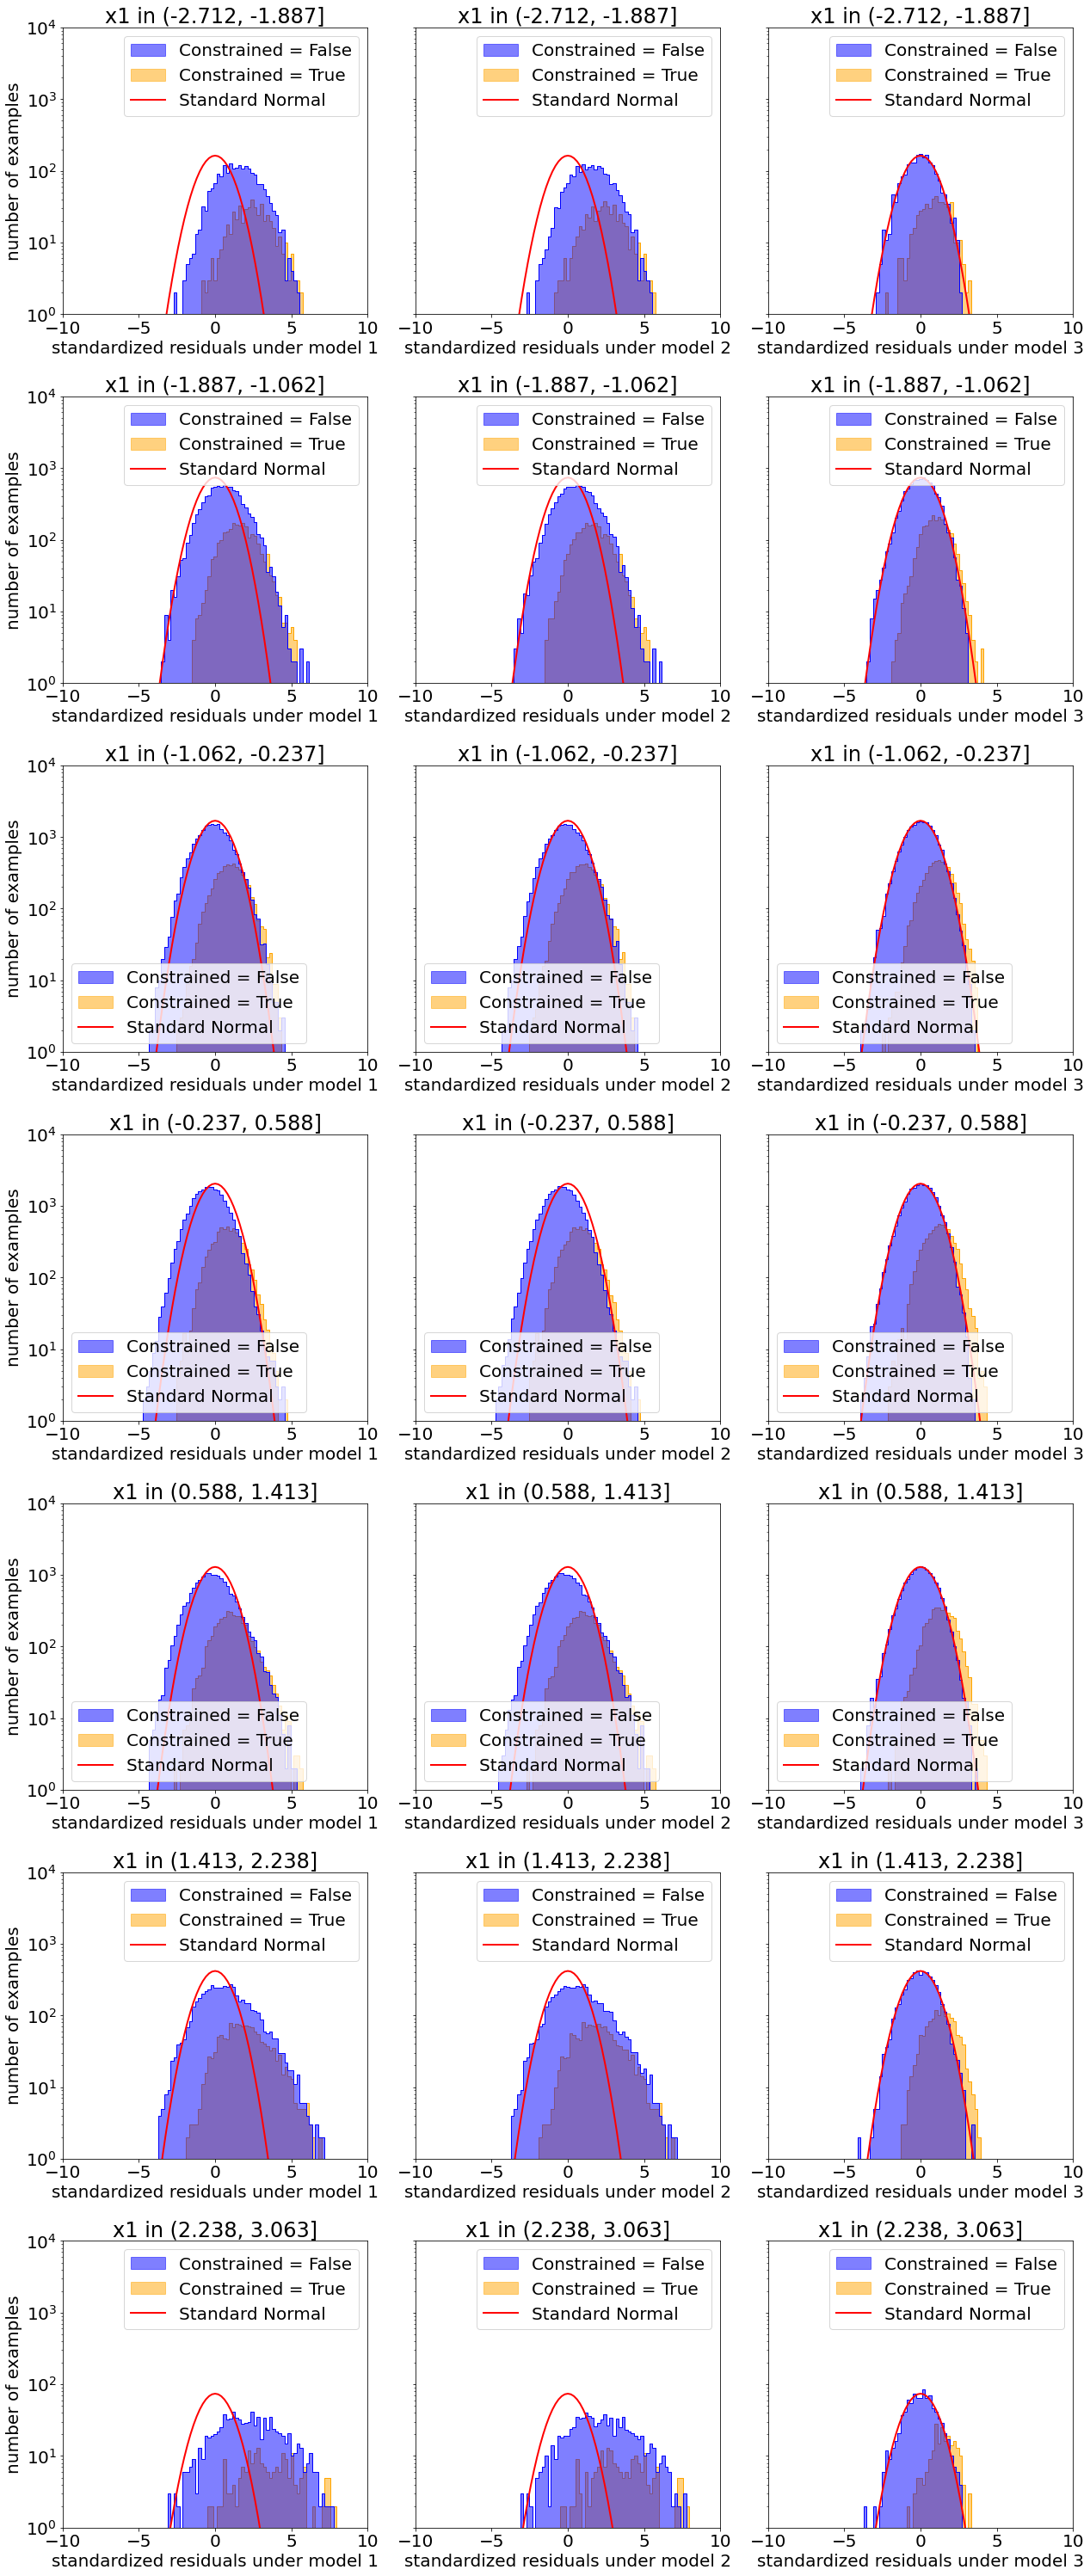

In [14]:
import seaborn as sns
from matplotlib.patches import Patch

NUMBER_EXAMPLES_MIN = 1000

def plot_residual_distributions():
    df = DATA.copy()

    df['x1_bin'] = (pd
        .cut(df['x1'], bins=10, labels=None)
    )
    groups = df.groupby('x1_bin')
    filtered_groups = {x1_bin: group for x1_bin, group in groups if len(group) > NUMBER_EXAMPLES_MIN}

    fig, axes = plt.subplots(len(filtered_groups), 3, figsize=(18, 6 * len(filtered_groups)), sharey=True)
    
    for i, (x1_bin, group) in enumerate(filtered_groups.items()):        
        for model_index in range(1, 4):
            ax = axes[i, model_index - 1] 

            bins = np.linspace(-10, 10, 100)
            bin_centers = (bins[1:] + bins[:-1]) / 2
            bin_width = bins[1] - bins[0]

            palette = {False: 'blue', True: 'orange'}
            alpha = 0.5  

            sns.histplot(
                data=group, 
                x=f'standardized_residuals_model{model_index}', 
                hue='constrained', 
                kde=False, 
                element='step', 
                bins=bins, 
                ax=ax, 
                palette=palette, 
                alpha=alpha
            )

            # plot standard normal 
            x = bin_centers
            y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
            negative_class_count = len(group[group['constrained'] == False])
            y_scaled = y * negative_class_count * bin_width  
            normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

            ax.set_xlabel(f'standardized residuals under model {model_index}')
            ax.set_ylabel('number of examples')
            ax.set_title(f'x1 in {x1_bin}')
            ax.set_yscale('log')  
            ax.set_xlim(-10, 10)
            ax.set_ylim(1, 1e4)

            # Manually create legend handles and labels
            handles = [
                Patch(color=palette[False], alpha=alpha),
                Patch(color=palette[True], alpha=alpha),
                normal_line
            ]
            labels = [
                'Constrained = False', 
                'Constrained = True', 
                'Standard Normal'
            ]
            ax.legend(handles=handles, labels=labels)

    plt.tight_layout()
    plt.show()

plot_residual_distributions()

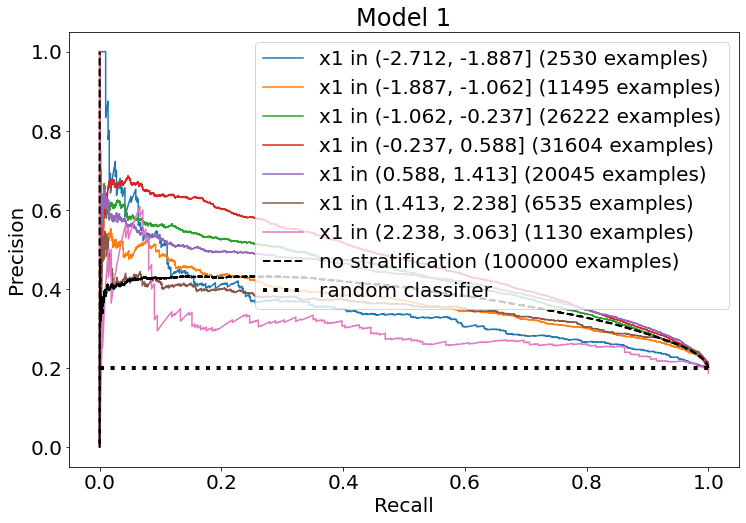

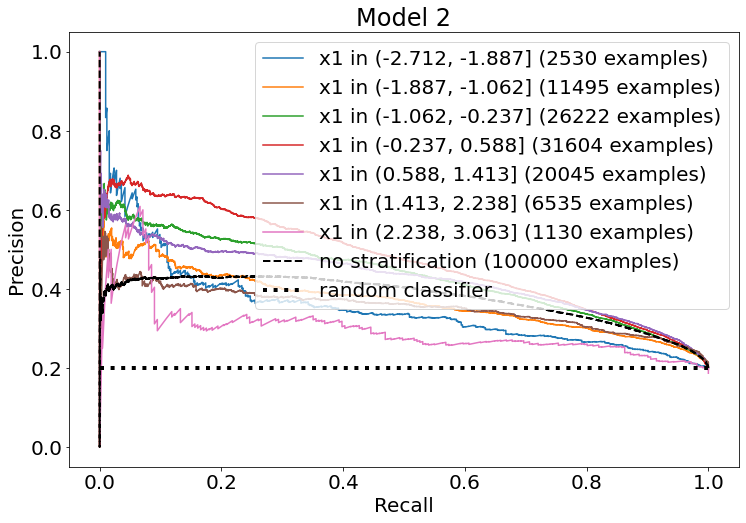

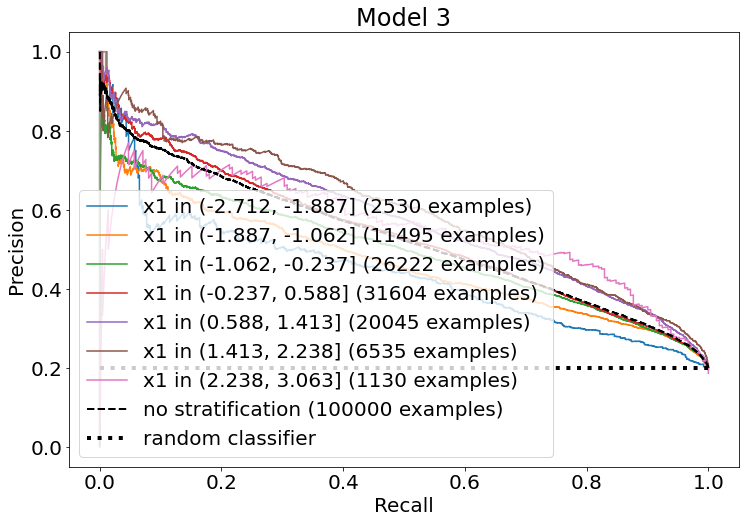

In [15]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curves(model_index, stratification_feature):
    df = DATA.copy()

    df[f'{stratification_feature}_bin'] = (pd
        .cut(df[stratification_feature], bins=10, labels=None)
    )
    groups = df.groupby(f'{stratification_feature}_bin')

    pr_curves = {}
    for x_bin, group in groups:        
        precision, recall, _ = precision_recall_curve(group['constrained'], group[f'standardized_residuals_model{model_index}'])
        pr_curves[x_bin] = (precision, recall, len(group))

    plt.figure(figsize=(12, 8))
    for x_bin, (precision, recall, num_examples) in pr_curves.items():
        if num_examples > NUMBER_EXAMPLES_MIN:
            plt.plot(recall, precision, label=f'{stratification_feature} in {x_bin} ({num_examples} examples)')

    # no stratification
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_model{model_index}'])
    plt.plot(recall, precision, label=f'no stratification ({len(df)} examples)', color='black', lw=2, linestyle='--')

    plt.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=4, linestyle=':', label='random classifier')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'Model {model_index}')
    plt.show()

def plot_pr_curves_wrapper(stratification_feature):
    plot_pr_curves(model_index=1, stratification_feature=stratification_feature)
    plot_pr_curves(model_index=2, stratification_feature=stratification_feature)
    plot_pr_curves(model_index=3, stratification_feature=stratification_feature)

plot_pr_curves_wrapper(stratification_feature='x1')

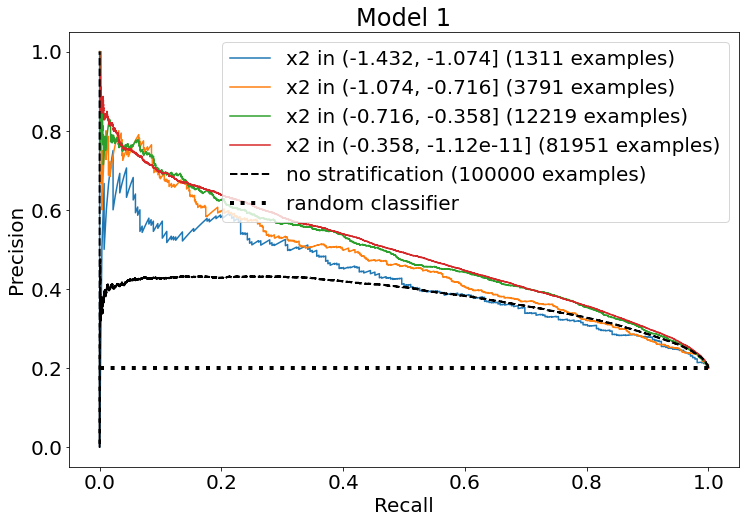

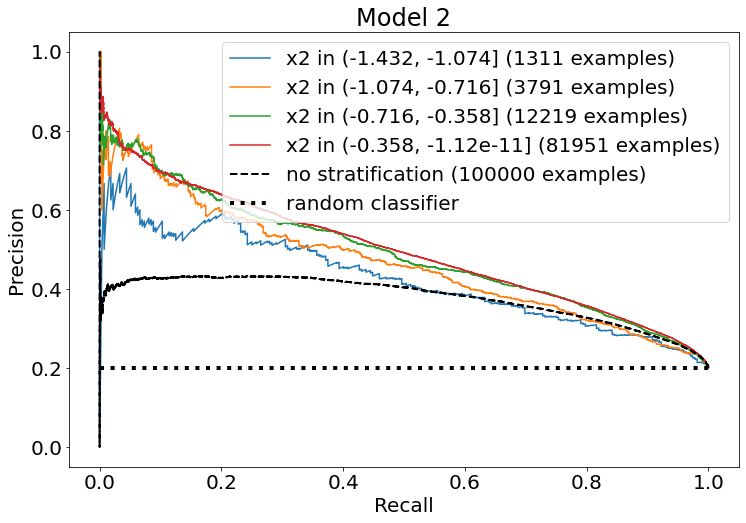

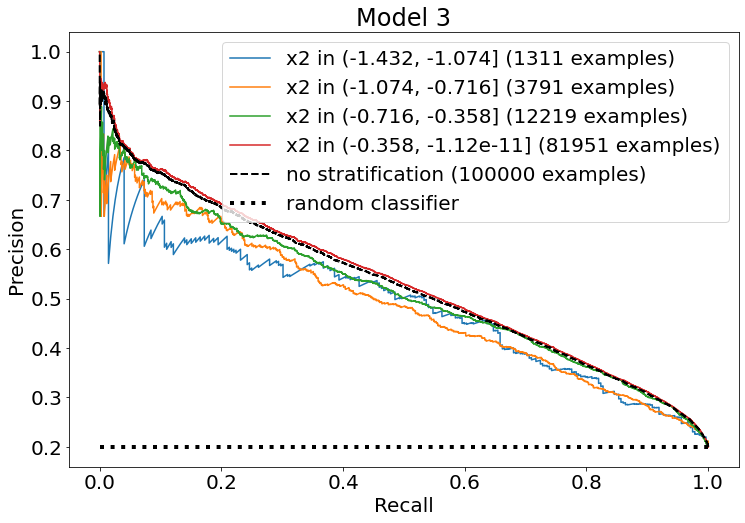

In [16]:
plot_pr_curves_wrapper(stratification_feature='x2')

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


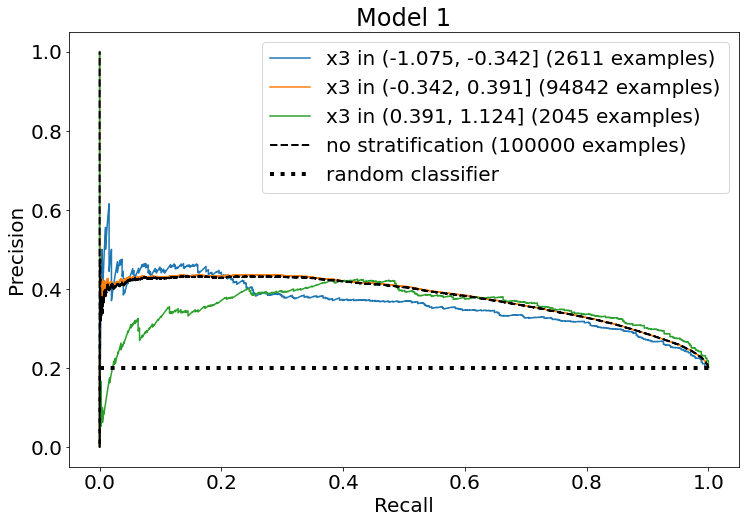

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


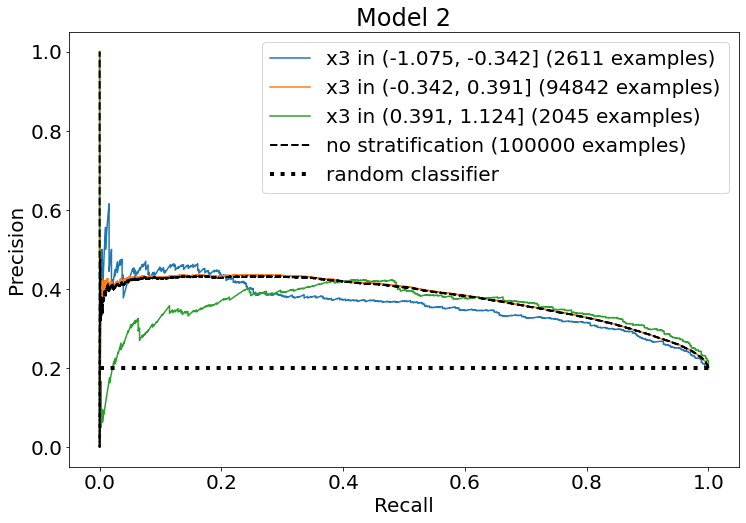

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


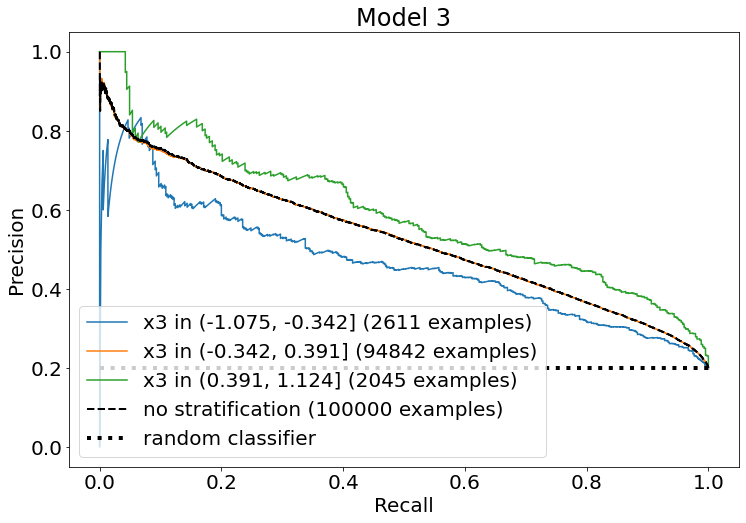

In [17]:
plot_pr_curves_wrapper(stratification_feature='x3')